# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [537]:
# import libraries


%autosave 60
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# standard libraries
from datetime import datetime as dt

# additional utilities
import numpy as np
import plotly.graph_objs as go
import plotly.offline as offline_py
offline_py.init_notebook_mode(connected=True)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import pyspark related libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.sql.types import *
from pyspark.sql.functions import col, isnan, when, trim



Autosaving every 60 seconds


In [538]:
# create a Spark session
spark = SparkSession.builder.appName("sparkify-chaitanya-capstone").getOrCreate()

In [539]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'sparkify-chaitanya-capstone'),
 ('spark.driver.port', '39897'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1578756696813'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'b5c119ec9208')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [540]:
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)

In [541]:
# Printing number of rows and columns
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18


In [542]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [543]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [544]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [545]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [546]:
pandas_dataframe = df.toPandas()
pandas_dataframe.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [547]:
pandas_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


In [548]:
pandas_dataframe.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


In [549]:
pandas_dataframe.userId.describe()

count     286500
unique       226
top           39
freq        9632
Name: userId, dtype: object

In [550]:
pandas_dataframe.sessionId.describe()

count    286500.000000
mean       1041.526555
std         726.776263
min           1.000000
25%         336.000000
50%        1013.000000
75%        1675.000000
max        2474.000000
Name: sessionId, dtype: float64

In [551]:
pandas_dataframe.page.unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
       'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object)

In [552]:
pandas_dataframe.level.unique()

array(['paid', 'free'], dtype=object)

In [553]:
# Explore the values of some categoric columns
pandas_dataframe.level.unique(), pandas_dataframe.method.unique(), pandas_dataframe.page.unique(), pandas_dataframe.status.unique(), pandas_dataframe.gender.unique(), pandas_dataframe.auth.unique()


(array(['paid', 'free'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'], dtype=object),
 array([200, 307, 404]),
 array(['M', 'F', None], dtype=object),
 array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object))

In [554]:
# Check for empty or null session ID

session_ids = pandas_dataframe.sessionId.unique().tolist()
empty_sess = 0
for id in session_ids:
    if id == '':
        empty_sess = empty_sess + 1
    elif id is None:
        empty_sess = empty_sess + 1
        
print(empty_sess)


0


In [555]:
pandas_dataframe.isna().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

**Dropping records without userId or sessionId**

Using the command pandas_dataframe = df.dropna(how = "any", subset = ["userId", "sessionId"])

Though we have found from the table above that no records with null userId or SessionId

Lets check for check for empty userId

In [556]:
pandas_dataframe[pandas_dataframe.userId == '']['userId'].count()

8346

#### Using Spark commands

In [557]:

df.filter(df.sessionId == '').count()


0

In [558]:
df.filter(df.userId == '').count()


8346

In [559]:
# Dropping the records with missing userId
df = df.filter(df.userId != '')

# Test : Result should be 0
df.filter(df.userId == '').count()

0

In [560]:
# removing the rows with missing userId and sessionId
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter(df_clean["userId"] != "")

#Converting to pandas dataframe for visualization
pandas_dataframe = df_clean.toPandas()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [561]:
pandas_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 18 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
dtypes: float64(1), int64(5), object(12)
memory usage: 38.2+ MB


In [562]:
pandas_dataframe.head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [563]:
df_clean.filter(df_clean.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(15)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
+------+
only showing top 15 rows



In [564]:
# clearly represent registration and timestamp by creating new columns
time_ts = udf(lambda x: dt.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df_clean = df_clean.withColumn("time", time_ts(df.ts))

In [565]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)



In [566]:
df_clean.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "125").sort("time").show(100)

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|               time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|10-12-2018 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|10-12-2018 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|10-12-2018 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|10-12-2018 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|10-12-2018 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|10-12-2018 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|10-12-2018 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|10-12-2018 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|10-12-2018 04:

**Lets churn the users based on the "Cancellation Confirmation" and "Submit Downgrade"**

In [567]:
# Churned user is defined as someone who has either "Submit Downgrade" or "Cancellation Confirmation" values on the page
# preparing a list of all such unique users

churned_usr = list(pandas_dataframe[pandas_dataframe['page'] == 'Submit Downgrade']['userId'].unique())
churned_usr.extend(list(pandas_dataframe[pandas_dataframe['page'] == 'Cancellation Confirmation']['userId'].unique()))
churned_usr = list(set(churned_usr))


In [568]:
# Creating dataframe of churn with respect to gender

uniq_userid = pandas_dataframe['userId'].unique().tolist()
gender_list = []

for userId in uniq_userid:
    gender_df.append(pandas_dataframe[pandas_dataframe['userId'] == userId]['gender'].iloc[0])
    
pandas_df_churn = pd.DataFrame({'userId': uniq_userid, 'gender': gender_list})
pandas_df_churn['churn'] = pandas_df_churn['userId'].apply(lambda x: 1 if x in churned_usr else 0)

In [569]:
pandas_df_churn.head(10)

,userId,gender,churn
0,30,M,1
1,9,M,1
2,74,F,1
3,54,F,1
4,4,M,0
5,101,M,1
6,78,F,0
7,88,F,0
8,95,F,1
9,25,F,1


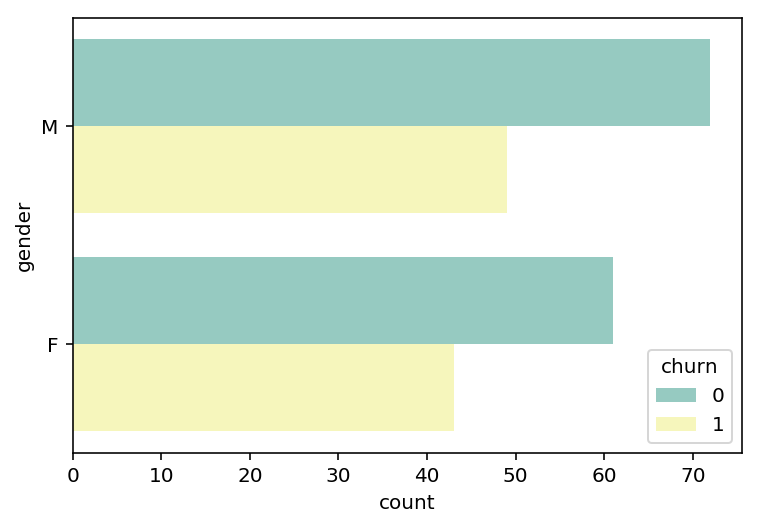

In [570]:
# Churn with respect to gender 
# 1 : user who has churned , 0 : user who has not churned

sns.countplot(y = "gender", hue = "churn", data = pandas_df_churn, palette="Set3")

In [571]:
# Compare churn with respect to level
# 1 : user who has churned , 0 : user who has not churned

level_list = []

for userId in uniq_userid:
    level.append(pandas_dataframe[pandas_dataframe['userId'] == userId]['level'].iloc[0])

pandas_df_churn_level = pd.DataFrame({'userId': uniq_userid, 'level': level_list})
pandas_df_churn_level['churn'] = pandas_df_churn_level['userId'].apply(lambda x: 1 if x in churned_usr else 0)

In [572]:
pandas_df_churn_level.head(10)

,userId,level,churn
0,30,paid,1
1,9,free,1
2,74,free,1
3,54,paid,1
4,4,free,0
5,101,free,1
6,78,free,0
7,88,free,0
8,95,paid,1
9,25,paid,1


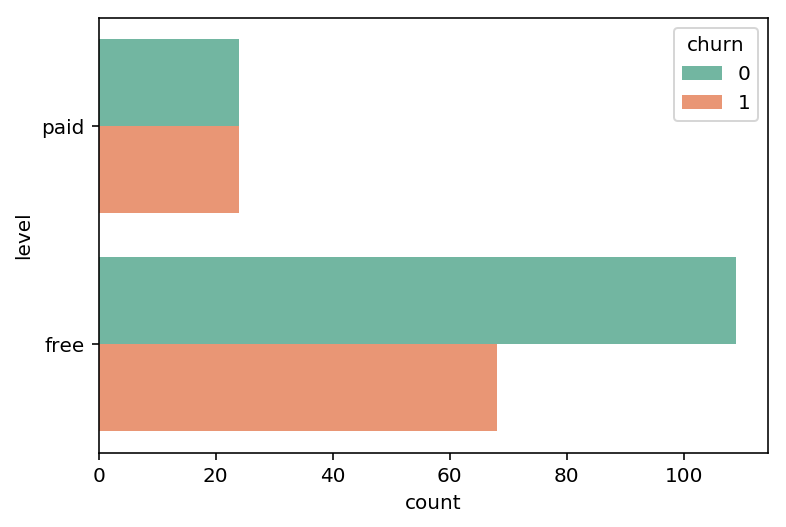

In [573]:
# Churn with respect to Level : chart
# 1 : user who has churned , 0 : user who has not churned

sns.countplot(y = "level", hue = "churn", data = pandas_df_churn_level, palette="Set2")

In [574]:
# Creating SQL table view for the data

df_clean.createOrReplaceTempView("sparkify_song_table_view")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [575]:
pandas_dataframe.page.value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Name: page, dtype: int64

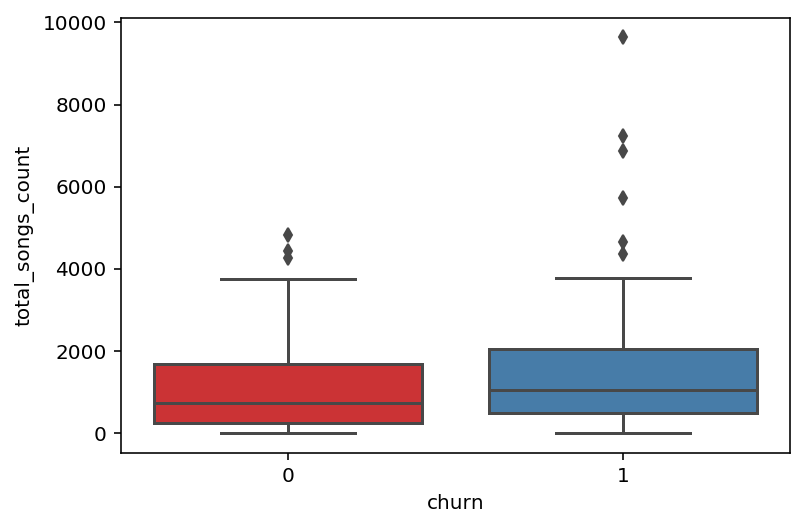

In [576]:
# Feature 1 : Total number of songs listened

total_songs_played = spark.sql("SELECT userId, count(*) as total_songs_count FROM sparkify_song_table_view group by userId")

pd_total_songs_played = total_songs_played.toPandas()
pd_total_songs_played['churn'] = pd_total_songs_played['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="total_songs_count", data=pd_total_songs_played , palette="Set1")


Interestingly the users that have cancelled or downgraded have listened to more songs.
Maybe they kept on switching the songs to find something they like.

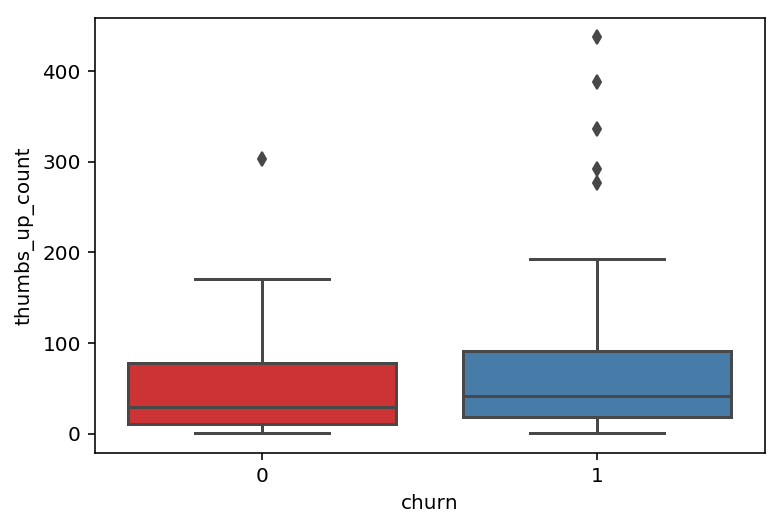

In [577]:
# Feature 2 : Number of thumbs up given by user

thumbs_up = spark.sql("SELECT userId, count(*) as thumbs_up_count FROM sparkify_song_table_view where page = 'Thumbs Up' group by userId")

pd_user_thumbs_up = thumbs_up.toPandas()
pd_user_thumbs_up['churn'] = pd_user_thumbs_up['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="thumbs_up_count", data=pd_user_thumbs_up, palette="Set1")


Not only the users that have cancelled or downgraded have listened to more songs, they have surprisingly liked more songs too.

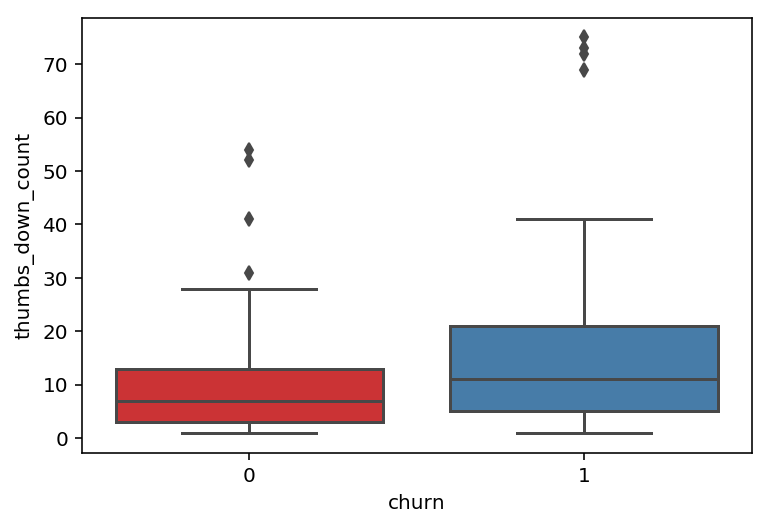

In [578]:
# Feature 3 : Number of thumbs down given by user

thumbs_dwn = spark.sql("SELECT userId, count(*) as thumbs_down_count FROM sparkify_song_table_view where page = 'Thumbs Down' group by userId")

pd_thumbs_down_usr = thumbs_dwn.toPandas()
pd_thumbs_down_usr['churn'] = pd_thumbs_down_usr['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="thumbs_down_count", data=pd_thumbs_down_usr, palette="Set1")


The users that have cancelled or downgraded have disliked more songs, as expected.
They clearly have a bigger difference in numbers of dislike with the other group in disliking a song than when we compare them in liking it.

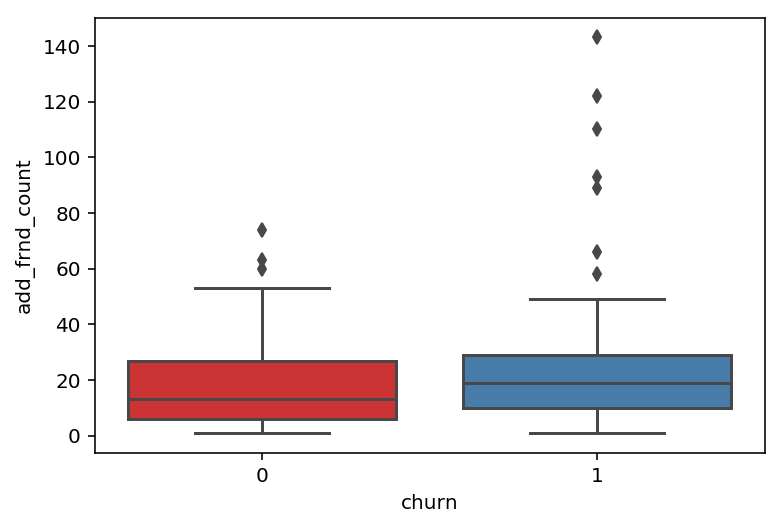

In [579]:
# Feature 4 : Number of users Added a friend

user_add_frnd = spark.sql("SELECT userId, count(*) as add_frnd_count FROM sparkify_song_table_view where page = 'Add Friend' group by userId")

pd_user_add_frnd = user_add_frnd.toPandas()
pd_user_add_frnd['churn'] = pd_user_add_frnd['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="add_frnd_count", data=pd_user_add_frnd, palette="Set1")


The users that have cancelled or downgraded have added a little more friends than the other group. The difference is not much.

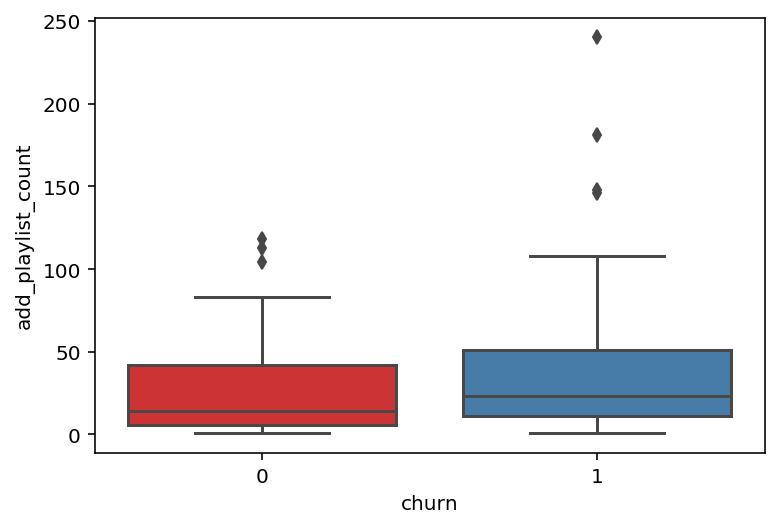

In [580]:
# Feature 5 : Number of users Added song to the playlist

user_add_playlist_count = spark.sql("SELECT userId, count(*) as add_playlist_count FROM sparkify_song_table_view where page = 'Add to Playlist' group by userId")

pd_user_add_playlist = user_add_playlist_count.toPandas()
pd_user_add_playlist['churn'] = pd_user_add_playlist['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="add_playlist_count", data=pd_user_add_playlist, palette="Set1")


Both user groups have similar types of distribution when it comes to adding a song to playlist.

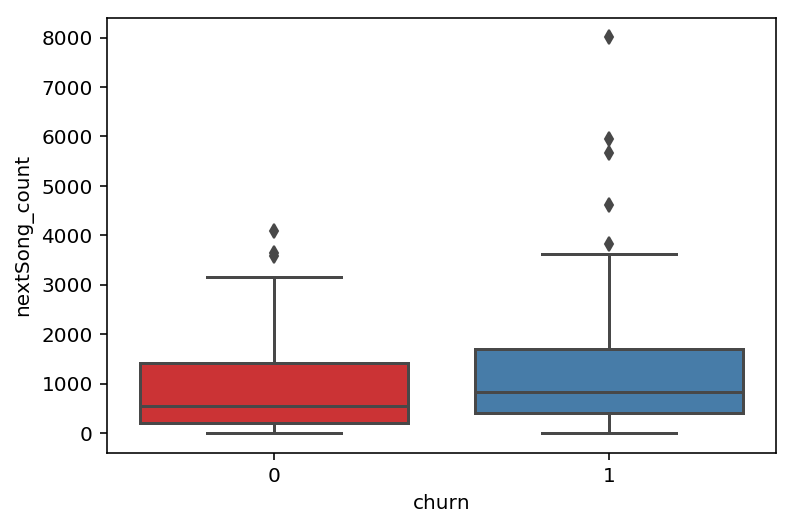

In [581]:
# Feature 6 : Number of users went for NextSong

user_nextSong_count = spark.sql("SELECT userId, count(*) as nextSong_count FROM sparkify_song_table_view where page = 'NextSong' group by userId")

pd_user_nextSong_count = user_nextSong_count.toPandas()
pd_user_nextSong_count['churn'] = pd_user_nextSong_count['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="nextSong_count", data=pd_user_nextSong_count, palette="Set1")


Interestingly more users from the group that cancelled or downgraded, went for a little more number of NextSong event on average. 

Given that they have listened to more number of songs, builds on the case for our hypothesis that these people were going through the songs but they didn't find expected number of songs to like.

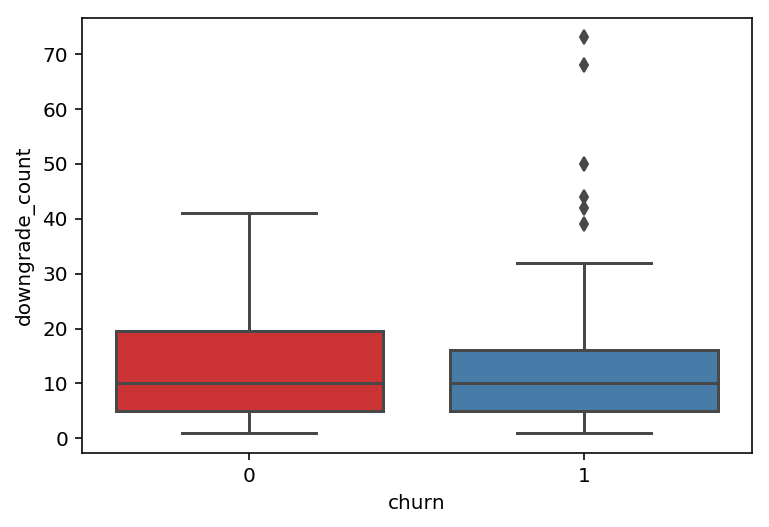

In [582]:
# Feature 7 : Number of users went for check for Downgrade

user_downgrade_count = spark.sql("SELECT userId, count(*) as downgrade_count FROM sparkify_song_table_view where page = 'Downgrade' group by userId")

pd_user_downgrade_count = user_downgrade_count.toPandas()
pd_user_downgrade_count['churn'] = pd_user_downgrade_count['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="downgrade_count", data=pd_user_downgrade_count, palette="Set1")


Surprisingly the users that cancelled or downgraded have checked for the Downgrade lesser than the other group.

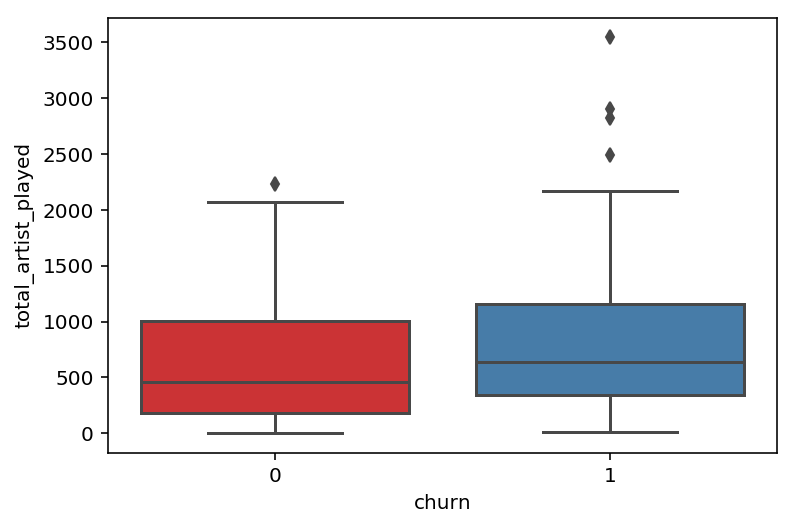

In [583]:
# Feature 8 : Total number of artists the user has listened to
num_artist = df_clean.filter(df_clean.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "total_artist_played")

pd_num_artist = num_artist.toPandas()
pd_num_artist['churn'] = pd_num_artist['userId'].apply(lambda x: 1 if x in churned_usr else 0)
sns.boxplot(x="churn", y="total_artist_played", data=pd_num_artist, palette="Set1")


The users that have cancelled or downgraded have listened to more number of Artists on average.

In [584]:
churn_from_view = spark.sql("SELECT userId, CASE when page = 'Submit Downgrade' or page = 'Cancellation Confirmation' THEN 1 END as churn from sparkify_song_table_view")


In [585]:
churn_from_view.createOrReplaceTempView('churn_table_view')
churn_no_null = spark.sql("SELECT * FROM churn_table_view where churn is not null")
churn_no_null.createOrReplaceTempView('churn_users_not_null')

In [586]:
data_temp = total_songs_played.join(thumbs_up,'userID','outer') \
    .join(thumbs_dwn,'userID','outer') \
    .join(user_add_frnd,'userID','outer') \
    .join(user_add_playlist_count,'userID','outer') \
    .join(user_nextSong_count,'userID','outer') \
    .join(user_downgrade_count,'userID','outer') \
    .join(num_artist,'userID','outer') \
    .fillna(0)

data_temp.show(5)

+------+-----------------+---------------+-----------------+--------------+------------------+--------------+---------------+-------------------+
|userId|total_songs_count|thumbs_up_count|thumbs_down_count|add_frnd_count|add_playlist_count|nextSong_count|downgrade_count|total_artist_played|
+------+-----------------+---------------+-----------------+--------------+------------------+--------------+---------------+-------------------+
|100010|              381|             17|                5|             4|                 7|           275|              0|                252|
|200002|              474|             21|                6|             4|                 8|           387|              5|                339|
|   125|               11|              0|                0|             0|                 0|             8|              0|                  8|
|   124|             4825|            171|               41|            74|               118|          4079|             41

In [587]:
data = data_temp.join(b, b.userId == data_temp.userId, "left_outer").drop(b.userId)

In [588]:
data.createOrReplaceTempView('final_table')
final_data_df = spark.sql("select userId, total_songs_count, thumbs_up_count, thumbs_down_count, add_frnd_count, add_playlist_count, nextSong_count, downgrade_count, total_artist_played, CASE when churn is null then 0 else 1 END as label from final_table")



In [589]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- total_songs_count: long (nullable = true)
 |-- thumbs_up_count: long (nullable = true)
 |-- thumbs_down_count: long (nullable = true)
 |-- add_frnd_count: long (nullable = true)
 |-- add_playlist_count: long (nullable = true)
 |-- nextSong_count: long (nullable = true)
 |-- downgrade_count: long (nullable = true)
 |-- total_artist_played: long (nullable = true)
 |-- churn: integer (nullable = true)



In [590]:
mySchema = StructType([ StructField("total_songs_count", IntegerType(), True)\
                       ,StructField("thumbs_up_count", DoubleType(), True)\
                       ,StructField("thumbs_down_count", DoubleType(), True)\
                       ,StructField("add_frnd_count", DoubleType(), True)\
                       ,StructField("add_playlist_count", DoubleType(), True)\
                       ,StructField("nextSong_count", IntegerType(), True)\
                       ,StructField("total_artist_played", IntegerType(), True)\
                       ,StructField("churn", IntegerType(), True)])

In [591]:
#df_new = spark.createDataFrame(df_final_pd,schema=mySchema)

In [592]:
def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))


In [593]:
#df_new.select([to_null(c).alias(c) for c in df_new.columns]).dropna().show()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [594]:
train_data, test_data = final_data_df.randomSplit([0.75, 0.25], seed=42)

In [595]:
final_data_df.columns

input_cols = ['total_songs_count','thumbs_up_count','thumbs_down_count','add_frnd_count',
              'add_playlist_count','nextSong_count','total_artist_played']

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
scale_feat = MinMaxScaler(inputCol="features", outputCol="feat_scaled")


In [596]:
# Method 1 : Random Forest

rf_clf = RandomForestClassifier(labelCol="label", featuresCol="feat_scaled", numTrees=7)
pipeline_rand_for = Pipeline(stages=[assembler, scale_feat, rf_clf])


grid_para = ParamGridBuilder().addGrid(rf_clf.numTrees,[3, 5]).build()

crossval_rand_for = CrossValidator(estimator=pipeline_rand_for,estimatorParamMaps=grid_para,evaluator=MulticlassClassificationEvaluator(),numFolds=4)

cross_vModel_rand_for = crossval_rand_for.fit(train_data)
#cvModel_rand_for.avgMetrics
results_rand_for = cross_vModel_rand_for.transform(test_data)
print("Random Forest Model has Accuracy of: ", round(results_rand_for.filter(results_rand_for.label == results_rand_for.prediction).count()/ results_rand_for.count() * 100,2), "%")

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_rand_for)
print("Random Forest Model's F1 score is: ", round(score*100,2), "%")


Random Forest Model has Accuracy of:  66.04 %
Random Forest Model's F1 score is:  66.28 %


In [597]:
# Method 2 : Logistic Regression

lr_clf =  LogisticRegression(labelCol="label", featuresCol="feat_scaled", maxIter=7, regParam=0.0, elasticNetParam=0)

pipeline_log_reg = Pipeline(stages=[assembler, scale_feat, lr_clf])

grid_para = ParamGridBuilder().addGrid(lr_clf.regParam,[0.0, 0.1]).build()

crossval_log_reg = CrossValidator(estimator=pipeline_log_reg,estimatorParamMaps=grid_para,evaluator=MulticlassClassificationEvaluator(),numFolds=2)

cross_vModel_log_reg = crossval_log_reg.fit(train_data)
#cvModel_log_reg.avgMetrics
results_log_reg = cross_vModel_log_reg.transform(test_data)
print("Logistic Regression Model has Accuracy of : ", round(results_log_reg.filter(results_log_reg.label == results_log_reg.prediction).count()/ results_log_reg.count() *100,2), "%")

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_log_reg)
print("Logistic Regression model has F1 score of : ", round(score*100,2), "%")



Logistic Regression Model has Accuracy of :  50.94 %
Logistic Regression model has F1 score of :  50.94 %


In [598]:
# Method 3 : SVM

svm_clf = LinearSVC(labelCol="label", featuresCol="feat_scaled", maxIter=7)
pipeline_svm = Pipeline(stages=[assembler, scale_feat, svm_clf])

grid_para = ParamGridBuilder().addGrid(svm_clf.maxIter,[3, 5]).build()

crossval_svm = CrossValidator(estimator=pipeline_svm,estimatorParamMaps=grid_para,evaluator=MulticlassClassificationEvaluator(),numFolds=2, collectSubModels=True)

cross_vModel_svm = crossval_svm.fit(train_data)
#cross_vModel_svm.avgMetrics
results_svm = cross_vModel_svm.transform(test_data)
print("SVM Model has Accuracy of : ", round(results_svm.filter(results_svm.label == results_svm.prediction).count()/ results_svm.count() * 100,2), "%")

evaluator = MulticlassClassificationEvaluator(metricName="f1")
score = evaluator.evaluate(results_svm)
print("SVM classifier has F1 score of  : ", round(score*100,2), "%")



SVM Model has Accuracy of :  58.49 %
SVM classifier has F1 score of  :  57.67 %


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.